# Yolo3 Finetuning on AWS

This series of notebooks demonstrates how to finetune MXNet YOLO v3 (aka YOLO3) on AWS.

**This notebook** walks through using the [MXNet Model Zoo](https://gluon-cv.mxnet.io/model_zoo/detection.html) on Localhost.

**Follow-on** the content of the notebooks shows:

* How to use MXNet YOLO3 pretrained model
* How to use Deep SORT with MXNet YOLO3
* How to create Ground-Truth dataset from images the model mis-detected
* How to finetune the model using the created dataset
* Load your finetuned model and Deploy Sagemaker-Endpoint with it.
* Apply Elastic Inference to your endpoint.

## Prerequisites

This notebook is designed to be run in Localhost. To run it (and understand what's going on), you'll need:

* Python 3.6+
* Basic familiarity with Python, Multi Object Detection

# Demo MXNet YOLO3

Before we get finetune the YOLO3 model, it is very helpful to use the model and see its results.

[MXNet Model Zoo](https://gluon-cv.mxnet.io/model_zoo/detection.html) is providing many pretrained models for object detection.

In this notebook, we are going to use `yolo3_darknet320_coco@320` model because its objectness and classification accuracy is very nice to demo and also its speed is acceptable even on `ml.t2.medium`.

* model postfixes, such as `@320`, `@416`, `@608`, are input image sizes. It is known that the input image size is propositional to model's accuracy.
* `accuracy` is not a correct word for explaining performance of object detector but we are going to stick with it in this series because the term is very intuitive for deeplearning muggles.

<img src="Assets/ModelZoo.png"/>

## Step 0: Dependencies and configuration

As usual we'll start by install external modules, loading libraries, defining configuration,

MXNet uses `Gluoncv` as its backend module, but sagemaker does not provide it by default. you should install it manually, and load libraries.

In [1]:
!pip install gluoncv mxnet==1.4.1, boto3 -U

Requirement already up-to-date: gluoncv in /Users/dongkyl/.pyenv/versions/3.7.4/lib/python3.7/site-packages (0.6.0)


In [2]:
%load_ext autoreload
%autoreload 1

# Built-Ins:
import os

# External Dependencies:
import boto3
import mxnet as mx
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils

## Step 1: Get Image

`Gluoncv` provides many useful `utils` module. 

* `utils.download` - download an image from internet and cache it into local directory.
* `utils.viz.plot_image` - display an image on the plot
* `utils.viz.plot_bbox` - display result of the object detection, such as bounding-box(bbox), class_names, confidence scores, along with the its original image.

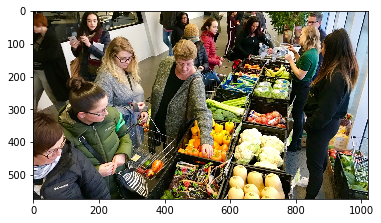

In [3]:
utils.download(
    'https://www.ctvnews.ca/polopoly_fs/1.4632164.1570679172!/httpImage/image.jpg_gen/derivatives/landscape_1020/image.jpg',
    path='market.jpg'
)
utils.viz.plot_image(mx.image.imread('market.jpg'))
plt.show()

## Step 2: Load Model

when you invoke `get_model`, it downloads model file, that is consists of network structure and parameters, of the given model from the internet and save it into local storage so that you can load it anytime you want. And it will be loaded when you give `pretrained` parameter as `True`

In [4]:
# load model
net = model_zoo.get_model('yolo3_darknet53_coco', pretrained=True)

## Step3: Detect Object

Every model has its own transforming ways for its train/test data as pre-processing. Properly pre-processed data increases model's accuracy drastically sometimes.

Gluoncv provides useful [tranform modules](https://gluon-cv.mxnet.io/api/data.transforms.html) for that and some presets for some pretrained models, such as SSD, Faster RCNN, Mask RCNN, and YOLO. By using these preset, you can easily transform input image and get decent result from the model.

In [5]:
# pre-process input image using preset for yolo3
x, img = data.transforms.presets.yolo.load_test('market.jpg', short=320)

In [6]:
def display(net, img, bbox, score, cid):
    '''display annotated image along with its original'''
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    utils.viz.plot_image(img, ax=ax1)
    utils.viz.plot_bbox(img, bbox[0], score[0],
                        cid[0], class_names=net.classes, ax=ax2)
    plt.show()

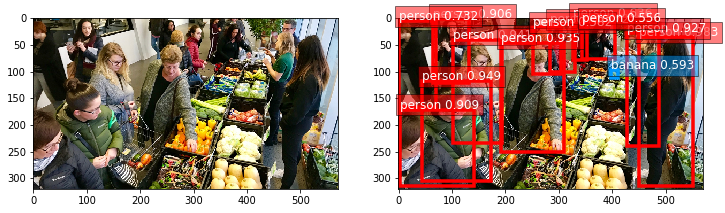

CPU times: user 4.22 s, sys: 230 ms, total: 4.45 s
Wall time: 1.66 s


In [7]:
%%time
# detel object using model
class_IDs, scores, bounding_boxs = net(x)

# display results along with original image
display(net, img, bounding_boxs, scores, class_IDs)

It works!! but do you notice the banana? if you resize image with `short=608` with transform function, you can see more bananas and apple in it.
What if you don't want to detect anything else but `person`?

Of course you can iterate `class_IDs` and just skip the index which is not `person`, but there is a more efficient way. You can `reset class`.


## Step4: Reset Class (Optional)

resetting class with `reuse_weights` params in YOLO increases inferecing performance.

In [8]:
# reset classes and reuse its weights
net.reset_class(classes=['person'], reuse_weights=['person'])

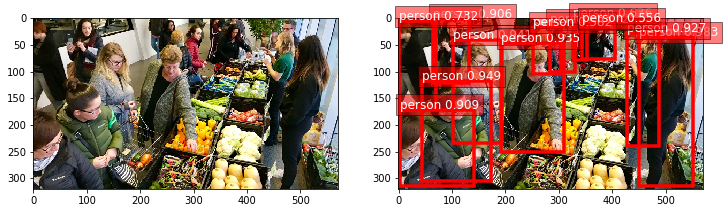

CPU times: user 3.36 s, sys: 148 ms, total: 3.51 s
Wall time: 1.2 s


In [9]:
%%time
# detel object using model
class_IDs, scores, bounding_boxs = net(x)

# display results along with original image
display(net, img, bounding_boxs, scores, class_IDs)